Name : JAINEEL PRAVIN PARMAR

Email : japarmar@syr.edu

All of the writing in this document is my original work, except for the code excerpts and any quoted material for which I have provided a citation

In [28]:
# CODE BLOCK 1
# Import necessary modules
import pickle
import numpy as np

In [29]:
# CODE BLOCK 2
# Load training and test data from pickle files

with open("train_qa.txt", "rb") as fp:
    train_data = pickle.load(fp)

In [30]:
# CODE BLOCK 3

with open("test_qa.txt", "rb") as fp:
    test_data = pickle.load(fp)

In [31]:
# CODE BLOCK 4
# Create vocabulary set from all data
vocab = set()

In [32]:
# CODE BLOCK 5
all_data = test_data + train_data

In [33]:
# CODE BLOCK 6
for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [34]:
# CODE BLOCK 7
# Add 'yes' and 'no' to vocabulary
vocab.add("yes")
vocab.add("no")

In [35]:
# CODE BLOCK 8
# Find maximum lengths of stories and questions
max_story_len = max([len(data[0]) for data in all_data])

max_ques_len = max([len(data[1]) for data in all_data])

In [37]:
# CODE BLOCK 9
# Pad and tokenize the training and test data
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters = [])

tokenizer.fit_on_texts(vocab)

In [38]:
# CODE BLOCK 10

train_story_text = []
train_question_text = []
train_answers = []

for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [39]:
# CODE BLOCK 11
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [40]:
# CODE BLOCK 12
# Define a function to vectorize the stories and questions
def vectorize_stories(data, word_index = tokenizer.word_index, max_story_len = max_story_len, max_ques_len = max_ques_len):
    X = []
    Xq = []
    Y = []

    for story, ques, ans in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in ques]
        y = np.zeros(len(word_index) + 1)
        y[word_index[ans]] = 1

        X.append(x)
        Xq.append(xq)
        Y.append(y)

    return(pad_sequences(X, maxlen = max_story_len), pad_sequences(Xq, maxlen = max_ques_len), np.array(Y))

In [42]:
# CODE BLOCK 13
# Vectorize the training and test data
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

inputs_test, queries_test, answers_test = vectorize_stories(test_data)

# Define the vocabulary length
vocab_len = len(vocab) + 1

In [43]:
# CODE BLOCK 14
# Import necessary layers for building model
from keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [44]:
# CODE BLOCK 15
# Define the input sequence and question inputs
input_sequence = Input((max_story_len,))
question = Input((max_ques_len,))

In [45]:
# CODE BLOCK 16
# Define the input encoder and question encoder layers
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim = vocab_len, output_dim = 64))
input_encoder_m.add(Dropout(0.3))

In [46]:
# CODE BLOCK 17
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim = vocab_len, output_dim = max_ques_len))
input_encoder_c.add(Dropout(0.3))

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim = vocab_len, output_dim = 64, input_length = max_ques_len))
question_encoder.add(Dropout(0.3))


# Encode the input sequence and question inputs
input_encoded_m = input_encoder_m(input_sequence)

input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

# Compute the match between the input sequence and the question
match = dot([input_encoded_m, question_encoded], axes = (2, 2))
match = Activation('softmax')(match)

response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

answer = concatenate([response, question_encoded])

answer = LSTM(32)(answer)

answer = Dropout(0.5)(answer)
answer = Dense(vocab_len)(answer)

answer = Activation('softmax')(answer)

model = Model([input_sequence, question], answer)
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential_3 (Sequential)      (None, None, 64)     2432        ['input_3[0][0]']                
                                                                                                  
 sequential_5 (Sequential)      (None, 6, 64)        2432        ['input_4[0][0]']                
                                                                                            

In [47]:
# CODE BLOCK 18
# Training the model with inputs_train, queries_train, and answers_train data and saving the training history to history

history = model.fit([inputs_train, queries_train], answers_train, batch_size = 30, epochs = 22, validation_data = ([inputs_test, queries_test], answers_test))

Epoch 1/22
334/334 [==============================] - 5s 10ms/step - loss: 0.9215 - accuracy: 0.4912 - val_loss: 0.6940 - val_accuracy: 0.4830
Epoch 2/22
334/334 [==============================] - 3s 9ms/step - loss: 0.7026 - accuracy: 0.5031 - val_loss: 0.7093 - val_accuracy: 0.5030
Epoch 3/22
334/334 [==============================] - 3s 9ms/step - loss: 0.6972 - accuracy: 0.4975 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 4/22
334/334 [==============================] - 3s 10ms/step - loss: 0.6944 - accuracy: 0.5065 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 5/22
334/334 [==============================] - 3s 9ms/step - loss: 0.6950 - accuracy: 0.4998 - val_loss: 0.6938 - val_accuracy: 0.5030
Epoch 6/22
334/334 [==============================] - 3s 9ms/step - loss: 0.6948 - accuracy: 0.4946 - val_loss: 0.6961 - val_accuracy: 0.5030
Epoch 7/22
334/334 [==============================] - 3s 9ms/step - loss: 0.6944 - accuracy: 0.4986 - val_loss: 0.6959 - val_accuracy: 0.4970
Epoc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 0, 'epochs')

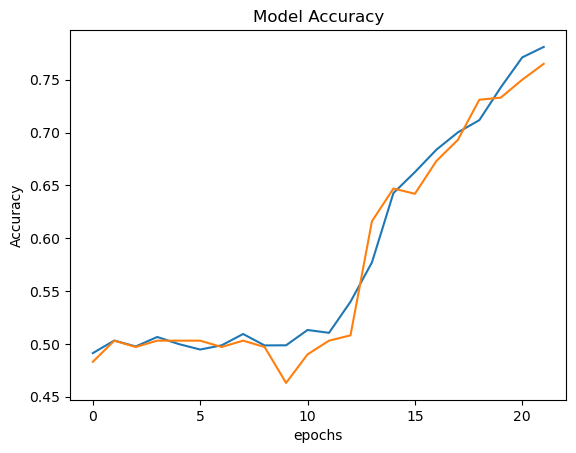

In [48]:
# CODE BLOCK 19

# Importing matplotlib library for visualizations
import matplotlib.pyplot as plt

# Printing the keys of the training history dictionary
print(history.history.keys())

# Plotting the accuracy of the model during training and validation epochs
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epochs")

In [49]:
# CODE BLOCK 20
# Saving the trained model

model.save("chatbot_model")

INFO:tensorflow:Assets written to: chatbot_model/assets


INFO:tensorflow:Assets written to: chatbot_model/assets


In [50]:
# CODE BLOCK 21
# Loading the saved model

model.load_weights("chatbot_model")

2023-04-11 19:54:15.230653: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open chatbot_model: FAILED_PRECONDITION: chatbot_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [51]:
# CODE BLOCK 22
# Generating prediction results on test data

pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 0s 4ms/step


In [52]:
# CODE BLOCK 23
# Accessing a single story in test_data and converting it into a string

test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [53]:
# CODE BLOCK 24
story = ' '.join(word for word in test_data[100][0])
story

'John took the apple there . John went to the bathroom .'

In [54]:
# CODE BLOCK 25
# Accessing a single query in test_data and converting it into a string

query = ' '.join(word for word in test_data[100][1])
query

'Is John in the hallway ?'

In [55]:
# CODE BLOCK 26
# Accessing the ground truth answer for a single story-query pair in test_data

test_data[100][2]

'no'

In [56]:
# CODE BLOCK 27

# Identifying the index of the predicted answer with the highest probability
val_max = np.argmax(pred_results[37])

# Mapping the predicted answer index to the corresponding word in the tokenizer.word_index dictionary
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

# Printing the predicted answer and its corresponding probability
print("Predicted answer is", k)
print("Probability of certainty", pred_results[37][val_max])

Predicted answer is yes
Probability of certainty 0.92389286
